In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
%tensorflow_version 2.x
import pathlib

from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt
from itertools import permutations
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

TensorFlow 2.x selected.


In [16]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cp gdrive/My\ Drive/celeb.zip .

In [0]:
%%capture
!unzip celeb.zip -d celeb

In [5]:
!pwd

/content


In [0]:
dataset_path = os.path.join('/content', 'celeb')
train_images_folder = pathlib.Path(os.path.join(dataset_path, 'train'))

train_image_paths = list(train_images_folder.glob('*/*'))
train_image_paths = [str(path) for path in train_image_paths]

train_full_labels = [pathlib.Path(path).parent.name for path in train_image_paths] #path is str

In [7]:
train_image_paths[:10]

['/content/celeb/train/Andy_Roddick/Andy_Roddick_0002.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0006.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0004.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0003.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0015.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0005.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0013.jpg',
 '/content/celeb/train/Andy_Roddick/Andy_Roddick_0010.jpg',
 '/content/celeb/train/Richard_Gephardt/Richard_Gephardt_0011.jpg',
 '/content/celeb/train/Richard_Gephardt/Richard_Gephardt_0006.jpg']

In [8]:
celeb_names = sorted(item.name for item in train_images_folder.glob('*/') if item.is_dir())
len(celeb_names)

143

In [9]:
label_to_index = dict((name, index) for index, name in enumerate(celeb_names))
label_to_index

{'Abdullah_Gul': 0,
 'Adrien_Brody': 1,
 'Alejandro_Toledo': 2,
 'Alvaro_Uribe': 3,
 'Amelie_Mauresmo': 4,
 'Andre_Agassi': 5,
 'Andy_Roddick': 6,
 'Angelina_Jolie': 7,
 'Ann_Veneman': 8,
 'Anna_Kournikova': 9,
 'Ari_Fleischer': 10,
 'Ariel_Sharon': 11,
 'Arnold_Schwarzenegger': 12,
 'Atal_Bihari_Vajpayee': 13,
 'Bill_Clinton': 14,
 'Bill_Gates': 15,
 'Bill_Simon': 16,
 'Britney_Spears': 17,
 'Carlos_Menem': 18,
 'Carlos_Moya': 19,
 'Catherine_Zeta-Jones': 20,
 'Charles_Moose': 21,
 'Colin_Powell': 22,
 'Condoleezza_Rice': 23,
 'David_Beckham': 24,
 'David_Nalbandian': 25,
 'Dick_Cheney': 26,
 'Dominique_de_Villepin': 27,
 'Donald_Rumsfeld': 28,
 'Edmund_Stoiber': 29,
 'Eduardo_Duhalde': 30,
 'Fidel_Castro': 31,
 'George_HW_Bush': 32,
 'George_Robertson': 33,
 'George_W_Bush': 34,
 'Gerhard_Schroeder': 35,
 'Gloria_Macapagal_Arroyo': 36,
 'Gonzalo_Sanchez_de_Lozada': 37,
 'Gordon_Brown': 38,
 'Gray_Davis': 39,
 'Guillermo_Coria': 40,
 'Halle_Berry': 41,
 'Hamid_Karzai': 42,
 'Hans_Blix

In [10]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths] #path is str

print("First 10 labels indices: ", all_labels[:10])
print("Length of all labels: ", len(all_labels))

First 10 labels indices:  [6, 6, 6, 6, 6, 6, 6, 6, 115, 115]
Length of all labels:  1144


In [0]:
# label_dict = {}

# celeb_count = 0
# for celebrity in os.listdir(dataset_path):
#   celeb_pic_path = os.path.join(dataset_path, celebrity)
#   label_dict[celeb_count] = {'celeb_name': celeb_pic_path,
#                   'celeb_pics': os.listdir(celeb_pic_path)}
#   celeb_count += 1

In [0]:
# X_flat = []
# y = []
# celeb_count = 0

# for celebrity in os.listdir(dataset_path):
#   celeb_pic_path = os.path.join(dataset_path, celebrity)
#   for pic in os.listdir(celeb_pic_path):
#     X_flat.append(os.path.join(celeb_pic_path, pic))
#     y.append(celeb_count)
#   celeb_count += 1

In [0]:
X_flat = train_image_paths
y = all_labels

In [12]:
print(len(X_flat))

1144


/content/celeb/train/Andy_Roddick/Andy_Roddick_0002.jpg


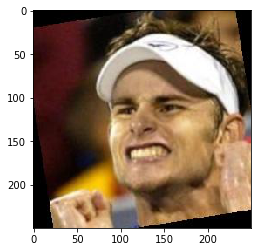

/content/celeb/train/Andy_Roddick/Andy_Roddick_0006.jpg


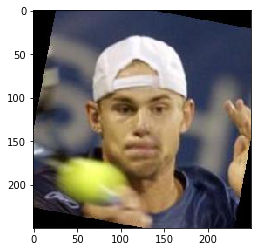

/content/celeb/train/Andy_Roddick/Andy_Roddick_0004.jpg


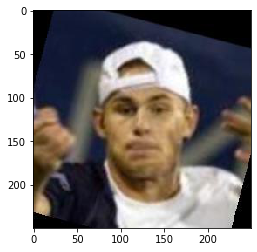

/content/celeb/train/Andy_Roddick/Andy_Roddick_0003.jpg


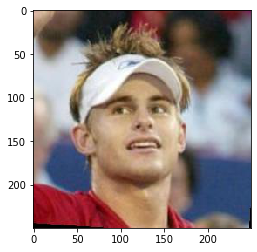

/content/celeb/train/Andy_Roddick/Andy_Roddick_0015.jpg


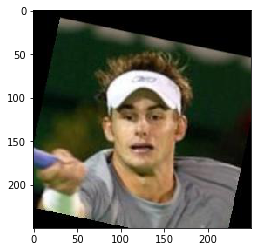

In [13]:
from PIL import Image
import numpy as np

for img in train_image_paths[:5]:
  print(img)
  pil_im = Image.open(img)
  im_array = np.asarray(pil_im)
  plt.imshow(im_array)
  plt.show()

In [14]:
im_array.shape

(250, 250, 3)

In [0]:
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 250
NUM_CHANNEL = 3

In [0]:
def generate_triplet(x,y,testsize=0.2, ap_pairs=10, an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    # triplet_train_pairs = []
    # triplet_test_pairs = []
    anchor_train, anchor_test =[], []
    positive_train, positive_test =[], []
    negative_train, negative_test =[], []

    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = plt.imread(data_xy[0][ap[0]])
            Positive = plt.imread(data_xy[0][ap[1]])
            for n in Neg_idx:
                Negative = plt.imread(data_xy[0][n])
                anchor_train.append(Anchor)
                positive_train.append(Positive)
                negative_train.append(Negative)
                # triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = plt.imread(data_xy[0][ap[0]])
            Positive = plt.imread(data_xy[0][ap[1]])
            for n in Neg_idx:
                Negative = plt.imread(data_xy[0][n])
                anchor_test.append(Anchor)
                positive_test.append(Positive)
                negative_test.append(Negative)
                # triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(anchor_train), np.array(anchor_test), np.array(positive_train), np.array(positive_test), np.array(negative_train), np.array(negative_test)

anchor_train, anchor_test, positive_train, positive_test, negative_train, negative_test = generate_triplet(X_flat, np.array(y), ap_pairs=5, an_pairs=5, testsize=0.2)

In [18]:
anchor_train.shape

(2860, 250, 250, 3)

In [19]:
anchor_test.shape

(715, 250, 250, 3)

In [0]:
# defining triplet loss
def triplet_loss(y_true, y_pred, alpha = 0.4):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [0]:
#from keras.applications.resnet50 import ResNet50

def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    # model = Sequential()
    # model.add(Conv2D(32, (3,3), padding='same', activation='relu',
    #                  input_shape=(in_dims[0],in_dims[1],in_dims[2],), name='conv1'))
    # model.add(MaxPooling2D((2,2), (2,2), padding='same', name='pool1'))

    # model.add(Conv2D(32, (3,3), padding='same', activation='relu', name='conv2'))
    # model.add(MaxPooling2D((2,2), (2,2), padding='same', name='pool2'))

    # model.add(Flatten(name='flatten'))
    # #model.add(Dense(64, activation='relu'))
    # model.add(Dense(4,name='embeddings'))
    # # model.add(Dense(600))
    
    # return model

    base_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    base_model.trainable = False 

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(100)

    # build a new model reusing the pretrained base
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])

    return model

In [0]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [26]:
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL,)

anchor_input = Input(IMG_SIZE, name='anchor_input')
positive_input = Input(IMG_SIZE, name='positive_input')
negative_input = Input(IMG_SIZE, name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network(IMG_SIZE)

encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

model.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 100)          23792612    anchor_input[0][0]               
                             

In [0]:
label_train = np.empty((anchor_train.shape[0],1))
label_test = np.empty((anchor_test.shape[0],1))

In [28]:
label_train.shape

(2860, 1)

In [29]:
#Y_dummy = np.empty((Anchor.shape[0],300))
model.fit(x=[anchor_train,positive_train,negative_train],
          y=np.array(label_train),
          validation_data=([anchor_test, positive_test, negative_test], np.array(label_test)),
          batch_size=64,
          epochs=10)

Train on 2860 samples, validate on 715 samples
Epoch 1/10
2860/2860 [==============================] - 39s 14ms/sample - loss: 2.9442 - val_loss: 5.2846
Epoch 2/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.7279 - val_loss: 4.9719
Epoch 3/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.2791 - val_loss: 4.8357
Epoch 4/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.1038 - val_loss: 4.7744
Epoch 5/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.0534 - val_loss: 4.7098
Epoch 6/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.0346 - val_loss: 4.6797
Epoch 7/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.0219 - val_loss: 4.6445
Epoch 8/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.0323 - val_loss: 4.6366
Epoch 9/10
2860/2860 [==============================] - 23s 8ms/sample - loss: 0.0183 - val_loss: 4.5949
Epoch 1

In [0]:
model.save_weights('resnet_triplet_model_celeb.hdf5')

In [0]:
np.sum((a1 - p1)**2)

151.55263

In [0]:
np.sum((p1 - n1)**2)

1891.3374

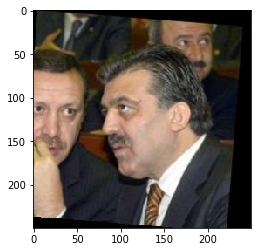

In [31]:
plt.imshow(anchor_test[0])
plt.show()

# Evaluation on test set

In [33]:
test_images_folder = pathlib.Path(dataset_path+'/test')
print(test_images_folder)

/content/celeb/test


In [0]:
test_image_paths = list(test_images_folder.glob('*/*'))
test_image_paths = [str(path) for path in test_image_paths]

In [35]:
print(len(test_image_paths))

286


In [36]:
test_image_paths[:10]

['/content/celeb/test/Andy_Roddick/Andy_Roddick_0012.jpg',
 '/content/celeb/test/Andy_Roddick/Andy_Roddick_0008.jpg',
 '/content/celeb/test/Richard_Gephardt/Richard_Gephardt_0003.jpg',
 '/content/celeb/test/Richard_Gephardt/Richard_Gephardt_0001.jpg',
 '/content/celeb/test/Ann_Veneman/Ann_Veneman_0002.jpg',
 '/content/celeb/test/Ann_Veneman/Ann_Veneman_0005.jpg',
 '/content/celeb/test/Tony_Blair/Tony_Blair_0117.jpg',
 '/content/celeb/test/Tony_Blair/Tony_Blair_0020.jpg',
 '/content/celeb/test/Eduardo_Duhalde/Eduardo_Duhalde_0008.jpg',
 '/content/celeb/test/Eduardo_Duhalde/Eduardo_Duhalde_0011.jpg']

In [0]:
test_labels = [pathlib.Path(path).parent.name for path in test_image_paths]

In [38]:
train_full_labels[:10]

['Andy_Roddick',
 'Andy_Roddick',
 'Andy_Roddick',
 'Andy_Roddick',
 'Andy_Roddick',
 'Andy_Roddick',
 'Andy_Roddick',
 'Andy_Roddick',
 'Richard_Gephardt',
 'Richard_Gephardt']

In [39]:
test_labels[:10]

['Andy_Roddick',
 'Andy_Roddick',
 'Richard_Gephardt',
 'Richard_Gephardt',
 'Ann_Veneman',
 'Ann_Veneman',
 'Tony_Blair',
 'Tony_Blair',
 'Eduardo_Duhalde',
 'Eduardo_Duhalde']

In [0]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('resnet_triplet_model_celeb.hdf5')

In [0]:
def read_image(image_path):
  return plt.imread(image_path)

In [0]:
train_images = list(map(read_image, train_image_paths))
test_images = list(map(read_image, test_image_paths))

In [0]:
train_images = np.array(train_images)
test_images = np.array(test_images)

In [44]:
train_images.shape

(1144, 250, 250, 3)

In [45]:
test_images.shape

(286, 250, 250, 3)

In [0]:
def get_embeddings(images):
  feature_list = trained_model.predict(images)
  return feature_list

In [0]:
train_embeddings = get_embeddings(train_images)

In [48]:
train_embeddings.shape

(1144, 100)

In [0]:
test_embeddings = get_embeddings(test_images)

In [50]:
test_embeddings.shape

(286, 100)

In [0]:
import IPython.display as display
correct_identified = 0
y_pred = []
for index, test_img_embedding in enumerate(test_embeddings):
  diff = (train_embeddings - test_img_embedding)**2
  dist = np.sum(diff, axis=1)
  # print(dist)
  nearest_neighbors = np.argsort(dist)[:10]
  # print(nearest_neighbors)
  # print(test_labels[index], train_full_labels[nearest_neighbors[0]])
  y_pred.append(all_labels[nearest_neighbors[0]])
  
  if test_labels[index] == train_full_labels[nearest_neighbors[0]]:
    # print(test_labels[index], train_full_labels[nearest_neighbors[0]])
    correct_identified += 1

  # show test image
  # display.display(display.Image(test_image_paths[index]))
  
  # # show the nearest images
  # for ind in nearest_neighbors:
  #   print(train_full_labels[ind])
  #   display.display(display.Image(train_image_paths[ind]))


In [57]:
correct_identified

42

In [0]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [0]:
y_true = [label_to_index[pathlib.Path(path).parent.name]
                    for path in test_image_paths] #path is str

In [60]:
y_true[:10]

[6, 6, 115, 115, 8, 8, 135, 135, 30, 30]

In [61]:
y_pred[:10]

[87, 130, 14, 114, 41, 8, 39, 102, 118, 27]

In [62]:
accuracy_score(y_true, y_pred)

0.14685314685314685

In [63]:
pr = np.zeros([143, 2])
pr[:, 0] =  precision_score(y_true, y_pred, average =None)
pr[:, 1] =  recall_score(y_true, y_pred, average =None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
from pandas import DataFrame as df
df(pr)

,0,1
0,0.500000,0.5
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0
...,...,...
138,0.000000,0.0
139,0.000000,0.0
140,0.000000,0.0
141,0.333333,0.5
